# EY PTE email to offer conversion prediction

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [2]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
query="""
SELECT * FROM ml_prep.gauthier_ey_pte_aop_email_to_offer ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


pnr point_of_sale language  loyalty_level  passenger_count  \
0  003Y3D            OM       en              0              3.0   
1  00AO7E            IT       en              0              NaN   
2  00C7IR            CH       en              0              3.0   

          email_sent_date segment_1_origination segment_1_destination  \
0 2019-09-02 06:08:44.725                   BOM                   AUH   
1 2019-07-19 07:41:31.296                   BOM                   AUH   
2 2019-12-17 11:08:00.667                   LHR                   AUH   

  segment_1_booked_fare_class segment_1_upgrade_cabin  ...  \
0                           Y       REGIONAL_BUSINESS  ...   
1                           Y       REGIONAL_BUSINESS  ...   
2                           Y              EXTRA_SEAT  ...   

   segment_4_booked_fare_class segment_4_upgrade_cabin  \
0                                                        
1                                                        
2                                                        

  segment_4_flight_number segment_4_carrier_code  \
0                     NaN                          
1                     NaN                          
2                     NaN                          

  segment_4_departure_local_date_time total_amount_itinerary_usd  \
0                                                            NaN   
1                                                            NaN   
2                                                            NaN   

  offer_item_count  first_offer_datetime has_offer         update_time  
0              NaN                   NaT     False 2020-07-21 14:28:13  
1              NaN                   NaT     False 2020-07-21 14:28:13  
2              NaN                   NaT     False 2020-07-21 14:28:13  

[3 rows x 39 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598708 entries, 0 to 1598707
Data columns (total 39 columns):
pnr                                    1598708 non-null object
point_of_sale                          1598708 non-null object
language                               1598708 non-null object
loyalty_level                          1598708 non-null int64
passenger_count                        1096863 non-null float64
email_sent_date                        1598708 non-null datetime64[ns]
segment_1_origination                  1598708 non-null object
segment_1_destination                  1598708 non-null object
segment_1_booked_fare_class            1598708 non-null object
segment_1_upgrade_cabin                1598708 non-null object
segment_1_flight_number                1043585 non-null float64
segment_1_carrier_code                 1598708 non-null object
segment_1_departure_local_date_time    1598708 non-null object
segment_2_origination                  1598708 non-null obj

# Feature Engineering

In [5]:
# compute some time-related features
# this takes some time

# email sent time
df['email_sent_day_of_week']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.dayofweek)
df['email_sent_hour']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.hour)
df['email_sent_month']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.month)
df['email_sent_year']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.year)
df["email_sent_days_before_departure"] =(pd.to_datetime(df["segment_1_departure_local_date_time"])-pd.to_datetime(df["email_sent_date"]).dt.tz_localize(None)).apply(lambda x: x.days)


In [6]:
# segment 1 
df['segment_1_departure_hour'] = pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_1_departure_day_of_week']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_1_departure_month']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_1_origin_destination'] = df['segment_1_origination']+ df['segment_1_destination']

# segment 2
df['segment_2_departure_hour'] = pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_2_departure_day_of_week']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_2_departure_month']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_2_origin_destination'] = df['segment_2_origination']+ df['segment_2_destination']

# segment 3
df['segment_3_departure_hour'] = pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_3_departure_day_of_week']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_3_departure_month']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_3_origin_destination'] = df['segment_3_origination']+ df['segment_3_destination']

# segment 4
df['segment_4_departure_hour'] = pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_4_departure_day_of_week']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_4_departure_month']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_4_origin_destination'] = df['segment_4_origination']+ df['segment_4_destination']

df['passenger_count'] = df['passenger_count'].fillna(0).astype(int)


In [7]:
df[:3]

pnr point_of_sale language  loyalty_level  passenger_count  \
0  003Y3D            OM       en              0                3   
1  00AO7E            IT       en              0                0   
2  00C7IR            CH       en              0                3   

          email_sent_date segment_1_origination segment_1_destination  \
0 2019-09-02 06:08:44.725                   BOM                   AUH   
1 2019-07-19 07:41:31.296                   BOM                   AUH   
2 2019-12-17 11:08:00.667                   LHR                   AUH   

  segment_1_booked_fare_class segment_1_upgrade_cabin  ...  \
0                           Y       REGIONAL_BUSINESS  ...   
1                           Y       REGIONAL_BUSINESS  ...   
2                           Y              EXTRA_SEAT  ...   

   segment_2_departure_month segment_2_origin_destination  \
0                          0                                
1                          0                                
2                          0                                

  segment_3_departure_hour segment_3_departure_day_of_week  \
0                        0                               0   
1                        0                               0   
2                        0                               0   

  segment_3_departure_month segment_3_origin_destination  \
0                         0                                
1                         0                                
2                         0                                

  segment_4_departure_hour  segment_4_departure_day_of_week  \
0                        0                                0   
1                        0                                0   
2                        0                                0   

  segment_4_departure_month segment_4_origin_destination  
0                         0                               
1                         0                               
2                         0                               

[3 rows x 60 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598708 entries, 0 to 1598707
Data columns (total 60 columns):
pnr                                    1598708 non-null object
point_of_sale                          1598708 non-null object
language                               1598708 non-null object
loyalty_level                          1598708 non-null int64
passenger_count                        1598708 non-null int64
email_sent_date                        1598708 non-null datetime64[ns]
segment_1_origination                  1598708 non-null object
segment_1_destination                  1598708 non-null object
segment_1_booked_fare_class            1598708 non-null object
segment_1_upgrade_cabin                1598708 non-null object
segment_1_flight_number                1043585 non-null float64
segment_1_carrier_code                 1598708 non-null object
segment_1_departure_local_date_time    1598708 non-null object
segment_2_origination                  1598708 non-null objec

# Feature Encoding

In [9]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [10]:
# label-encode categories
# there is no channel source since it's always PTE.
columns = ['language','point_of_sale'] + \
['segment_1_origination','segment_1_destination','segment_1_origin_destination','segment_1_booked_fare_class','segment_1_upgrade_cabin']+ \
['segment_2_origination','segment_2_destination','segment_2_origin_destination','segment_2_booked_fare_class','segment_2_upgrade_cabin'] + \
['segment_3_origination','segment_3_destination','segment_3_origin_destination','segment_3_booked_fare_class','segment_3_upgrade_cabin'] + \
['segment_4_origination','segment_4_destination','segment_4_origin_destination','segment_4_booked_fare_class','segment_4_upgrade_cabin'] 

df= label_encode_categorical(df,columns)


label encoding language ...
label encoding point_of_sale ...
label encoding segment_1_origination ...
label encoding segment_1_destination ...
label encoding segment_1_origin_destination ...
label encoding segment_1_booked_fare_class ...
label encoding segment_1_upgrade_cabin ...
label encoding segment_2_origination ...
label encoding segment_2_destination ...
label encoding segment_2_origin_destination ...
label encoding segment_2_booked_fare_class ...
label encoding segment_2_upgrade_cabin ...
label encoding segment_3_origination ...
label encoding segment_3_destination ...
label encoding segment_3_origin_destination ...
label encoding segment_3_booked_fare_class ...
label encoding segment_3_upgrade_cabin ...
label encoding segment_4_origination ...
label encoding segment_4_destination ...
label encoding segment_4_origin_destination ...
label encoding segment_4_booked_fare_class ...
label encoding segment_4_upgrade_cabin ...


In [11]:
columns_for_training= [    
                        # segment 1
                        'segment_1_origination_encoded',
                        'segment_1_destination_encoded',
                        'segment_1_origin_destination_encoded',
                        'segment_1_booked_fare_class_encoded',
                        'segment_1_upgrade_cabin_encoded',
    
                         # segment 2
                        'segment_2_origination_encoded',
                        'segment_2_destination_encoded',
                        'segment_2_origin_destination_encoded',
                        'segment_2_booked_fare_class_encoded',
                        'segment_2_upgrade_cabin_encoded',

                         # segment 3
                        'segment_3_origination_encoded',
                        'segment_3_destination_encoded',
                        'segment_3_origin_destination_encoded',
                        'segment_3_booked_fare_class_encoded',
                        'segment_3_upgrade_cabin_encoded',

                         # segment 4
                        'segment_4_origination_encoded',
                        'segment_4_destination_encoded',
                        'segment_4_origin_destination_encoded',
                        'segment_4_booked_fare_class_encoded',
                        'segment_4_upgrade_cabin_encoded',
    
                        # email
                        'email_sent_day_of_week',
                        'email_sent_hour',
                        'email_sent_month',
                        'email_sent_year',
                        'email_sent_days_before_departure',
    
    
    
                       # the rest
                       'language_encoded',
                       'passenger_count',
                       'point_of_sale_encoded',

                       # target
                        'has_offer',
                      ]

df_train = df[columns_for_training]

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598708 entries, 0 to 1598707
Data columns (total 29 columns):
segment_1_origination_encoded           1598708 non-null int64
segment_1_destination_encoded           1598708 non-null int64
segment_1_origin_destination_encoded    1598708 non-null int64
segment_1_booked_fare_class_encoded     1598708 non-null int64
segment_1_upgrade_cabin_encoded         1598708 non-null int64
segment_2_origination_encoded           1598708 non-null int64
segment_2_destination_encoded           1598708 non-null int64
segment_2_origin_destination_encoded    1598708 non-null int64
segment_2_booked_fare_class_encoded     1598708 non-null int64
segment_2_upgrade_cabin_encoded         1598708 non-null int64
segment_3_origination_encoded           1598708 non-null int64
segment_3_destination_encoded           1598708 non-null int64
segment_3_origin_destination_encoded    1598708 non-null int64
segment_3_booked_fare_class_encoded     1598708 non-null int64
segme

In [13]:
df_train.head(4)

segment_1_origination_encoded  segment_1_destination_encoded  \
0                             12                              4   
1                             12                              4   
2                             50                              4   
3                             12                              4   

   segment_1_origin_destination_encoded  segment_1_booked_fare_class_encoded  \
0                                    90                                   17   
1                                    90                                   17   
2                                   128                                   17   
3                                    90                                   17   

   segment_1_upgrade_cabin_encoded  segment_2_origination_encoded  \
0                                5                              0   
1                                5                              0   
2                                3                              0   
3                                5                              0   

   segment_2_destination_encoded  segment_2_origin_destination_encoded  \
0                              0                                     0   
1                              0                                     0   
2                              0                                     0   
3                              0                                     0   

   segment_2_booked_fare_class_encoded  segment_2_upgrade_cabin_encoded  ...  \
0                                    0                                0  ...   
1                                    0                                0  ...   
2                                    0                                0  ...   
3                                    0                                0  ...   

   segment_4_upgrade_cabin_encoded  email_sent_day_of_week  email_sent_hour  \
0                                0                       0                6   
1                                0                       4                7   
2                                0                       1               11   
3                                0                       0                6   

   email_sent_month  email_sent_year  email_sent_days_before_departure  \
0                 9             2019                               105   
1                 7             2019                                40   
2                12             2019                                 3   
3                12             2019                                 5   

   language_encoded  passenger_count  point_of_sale_encoded  has_offer  
0                 2                3                     39      False  
1                 2                0                     27      False  
2                 2                3                      9      False  
3                 2                1                     41      False  

[4 rows x 29 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffae6f055c0>]],
      dtype=object)

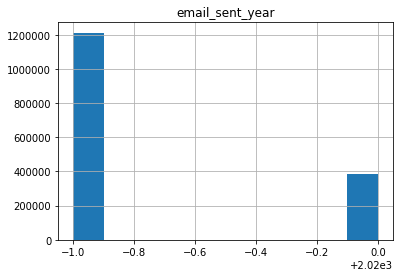

In [14]:
# we could use month to split train/test data
pd.DataFrame.hist(df_train,column='email_sent_year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb05580ef0>]],
      dtype=object)

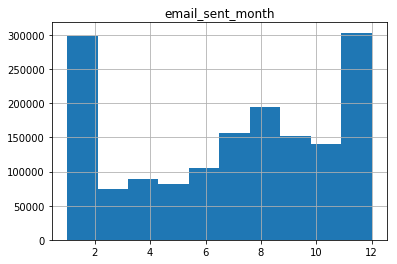

In [23]:
# we could use month to split train/test data
pd.DataFrame.hist(df_train,column='email_sent_month')

# Model Training & Evaluation

In [15]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [16]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("has_offer", axis=1)
    y = df_to_train["has_offer"]

    
    if split_on_time:
        X_train = X[X["email_sent_year"] == 2019 ].drop("email_sent_year", axis=1)
        y_train = y[X["email_sent_year"] == 2019]
        X_test = X[X["email_sent_year"] == 2020].drop("email_sent_year", axis=1)
        y_test = y[X["email_sent_year"] == 2020]
        print('split on time')
    else:
        X = X.drop("email_sent_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    print('y_test_proba',y_test_proba)
    print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    for feature,importance in zip(features[indices],importances[indices]):
        print(feature+','+str(importance))
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)



random split
training on 1119095 rows...
training is done!
y_test_proba [0.04 0.   0.   ... 0.   0.   0.  ]
y_test_predict [False False False ... False False False]
precision 0.1877637130801688
recall 0.018847945785684033
f1 0.034257120862201694
support 4722
roc auc 0.8164079281873525
email_sent_days_before_departure,0.11313135754372451
email_sent_day_of_week,0.11207381059241787
email_sent_hour,0.10129228214311618
email_sent_month,0.083937984381274
segment_1_booked_fare_class_encoded,0.07591576132139145
segment_1_origin_destination_encoded,0.062258876818823215
segment_2_booked_fare_class_encoded,0.05072073489357626
segment_2_origin_destination_encoded,0.04955257391195667
passenger_count,0.04682589578119636
point_of_sale_encoded,0.04662985064556705
segment_1_origination_encoded,0.03536788070899344
segment_2_destination_encoded,0.032406151520721224
segment_1_destination_encoded,0.02988073980186923
segment_1_upgrade_cabin_encoded,0.019695502332334303
segment_3_origin_destination_encoded,0

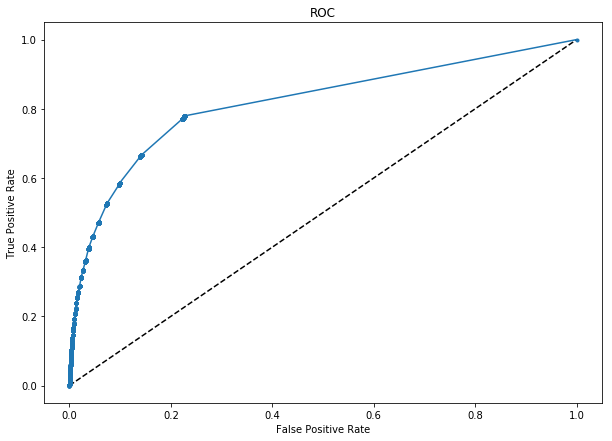

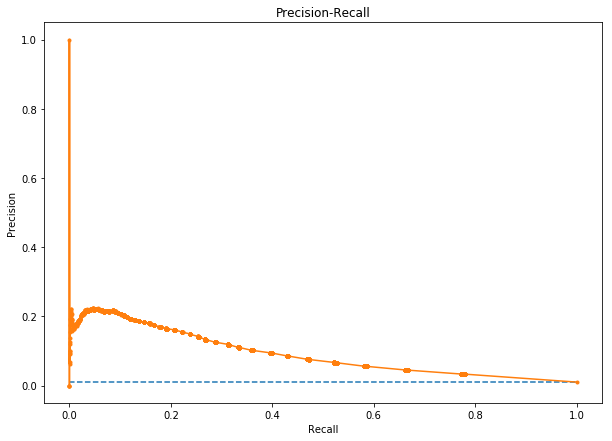

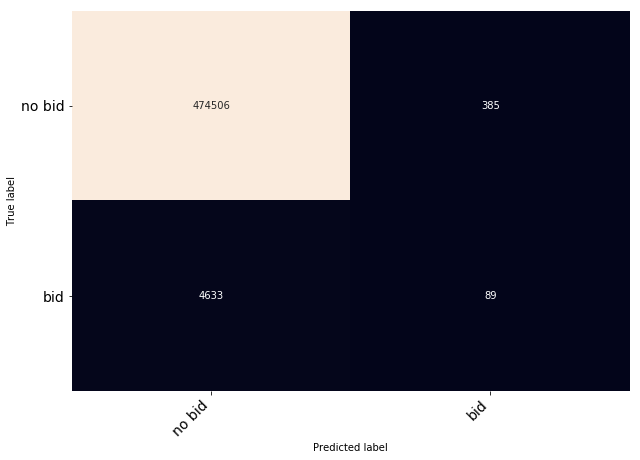

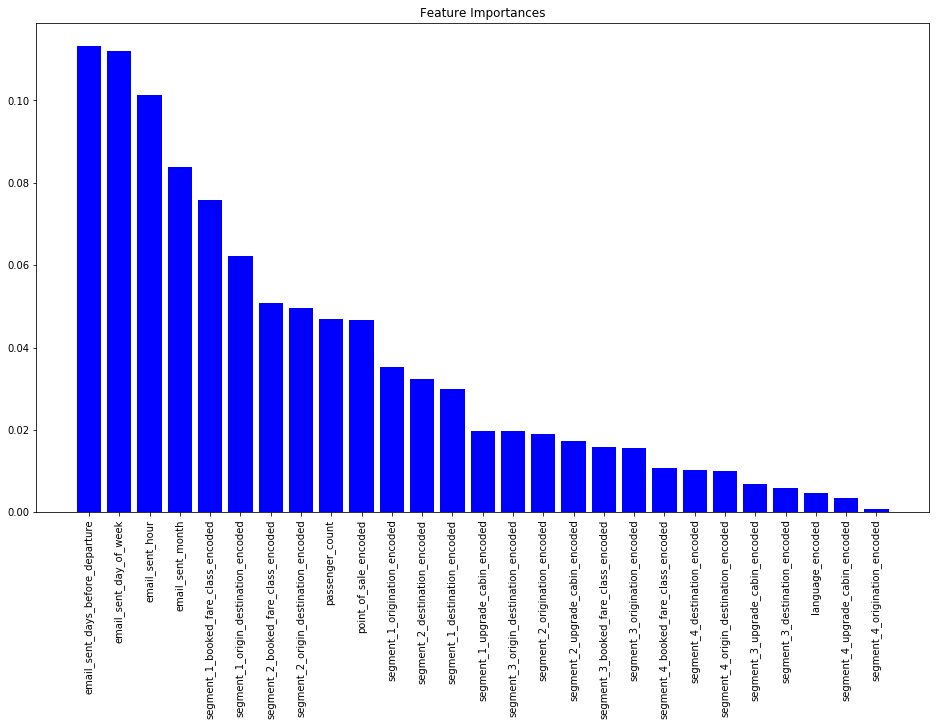

In [17]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=None)

split on time
training on 1212758 rows...
training is done!
y_test_proba [0.         0.         0.         ... 0.05166667 0.04       0.05      ]
y_test_predict [False False False ... False False False]
precision 0.06944444444444445
recall 0.0013119916032537393
f1 0.0025753283543651817
support 3811
roc auc 0.7190950307860798
email_sent_days_before_departure,0.12227651528512401
email_sent_day_of_week,0.11354450841185319
email_sent_hour,0.09852403217385924
email_sent_month,0.08081770992645841
segment_1_booked_fare_class_encoded,0.07737076530420006
segment_1_origin_destination_encoded,0.06002756709680611
segment_2_booked_fare_class_encoded,0.05316352484684547
passenger_count,0.04899949837419303
segment_2_origin_destination_encoded,0.048167876364899206
point_of_sale_encoded,0.045221651536635
segment_1_origination_encoded,0.03493634118506975
segment_2_destination_encoded,0.032124866391909
segment_1_destination_encoded,0.028479784440450698
segment_3_origin_destination_encoded,0.01942095649212

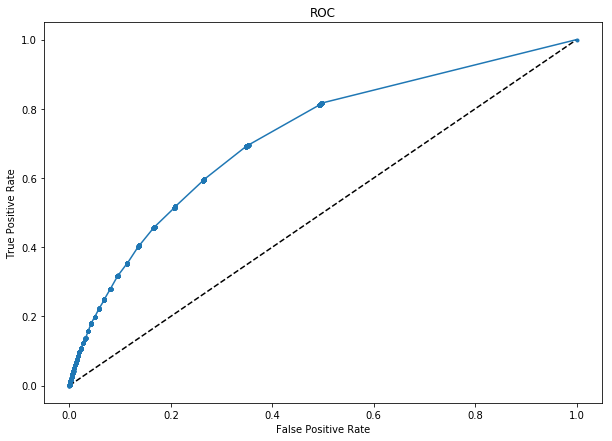

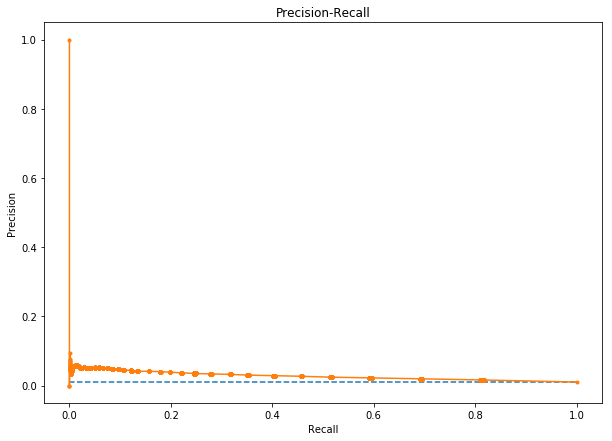

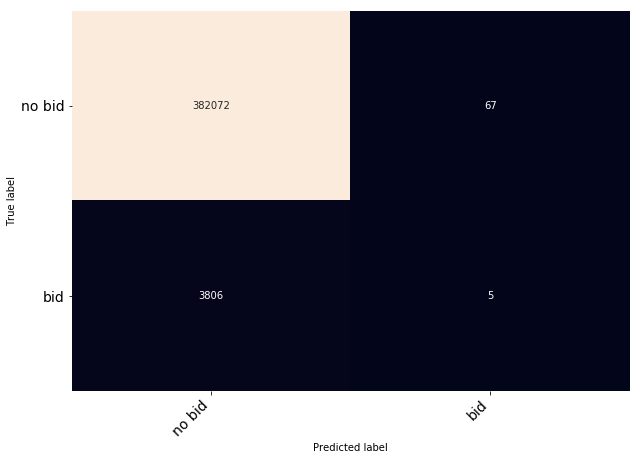

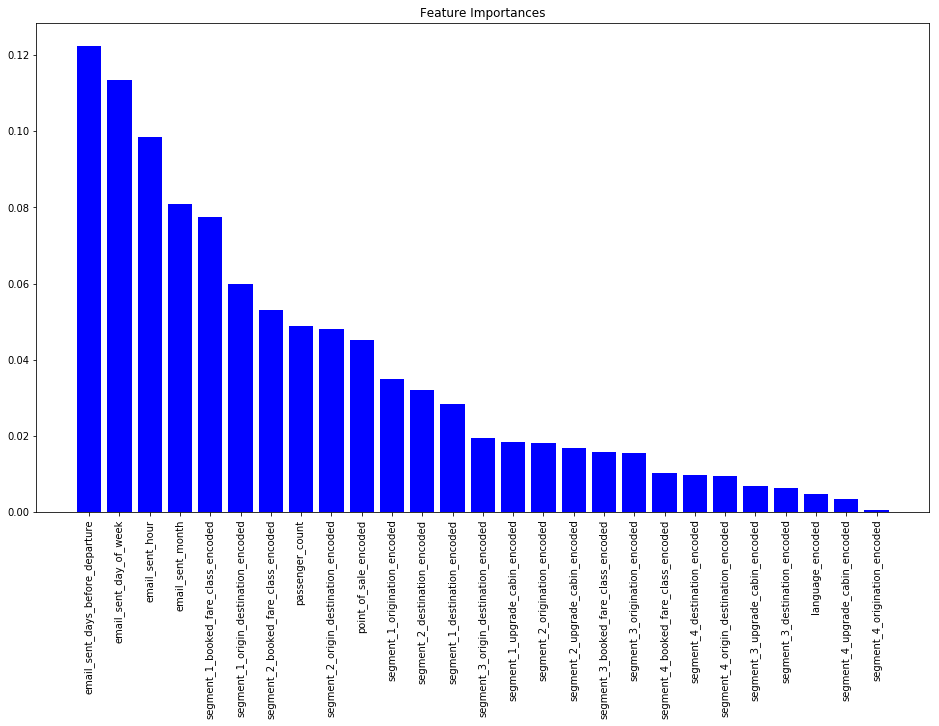

In [18]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=None, split_on_time=True)

In [19]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()


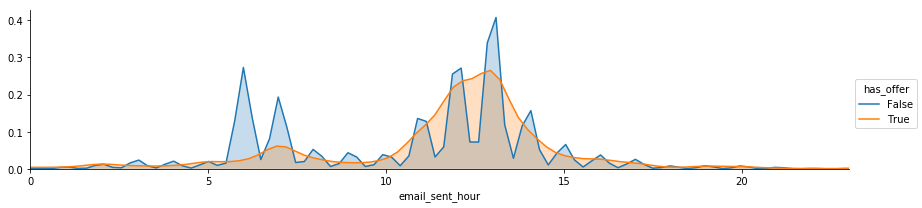

In [20]:
plot_distribution( df , var = 'email_sent_hour' , target = 'has_offer' )

In [21]:
aggregate = df.groupby(['email_sent_hour'])['has_offer'].agg(['size','sum'])
aggregate['conversion_%'] = aggregate['sum'] / aggregate['size'] * 100.0

In [22]:
aggregate

size     sum  conversion_%
email_sent_hour                              
0                  1756    69.0      3.929385
1                  4347    66.0      1.518288
2                 11058   220.0      1.989510
3                 20108   119.0      0.591804
4                 17227   122.0      0.708191
5                 16707   314.0      1.879452
6                222269   294.0      0.132272
7                159559  1069.0      0.669972
8                 44156   390.0      0.883232
9                 37651   231.0      0.613530
10                34724   319.0      0.918673
11               129626  1591.0      1.227377
12               259456  3599.0      1.387133
13               369610  4301.0      1.163659
14               136326  1402.0      1.028417
15                55332   471.0      0.851225
16                31195   407.0      1.304696
17                21150   244.0      1.153664
18                 6619    46.0      0.694969
19                 7248   124.0      1.710817
20                 6761    97.0      1.434699
21                 3597    27.0      0.750626
22                 1111    13.0      1.170117
23                 1115    15.0      1.345291